# Introduction

In this notebook, we cover the process of training the best possible model to classify MRI images of brain tumours.

# Importing Modules
We first start by importing all the modules we need to proceed with this project.

In [32]:
import os
import numpy as np

from sklearn.model_selection import train_test_split, ParameterGrid
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

Model = tf.keras.models.Model
VGG19 = tf.keras.applications.VGG19
ResNet50 = tf.keras.applications.ResNet50

GlobalAveragePooling2D = tf.keras.layers.GlobalAveragePooling2D
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout

# Configuring Global Constants
We need to define some global constants to keep things consistent across the notebook. This will allow us to use the same constant that could contain different values based on the configuration.

In [5]:
ON_COLAB = True

Since running this in the local computer takes a huge amount of time behind hardware acceleration, we have two configurations that we can load.

In [6]:
if ON_COLAB:
    # mound google drive
    from google.colab import drive

    DRIVE_ROOT = "/content/drive"
    DRIVE_DATA_ROOT = os.path.join(DRIVE_ROOT, "My Drive/CP322")
    DRIVE_TRAINING_FOLDER = os.path.join(DRIVE_DATA_ROOT, "Training")
    DRIVE_TESTING_FOLDER = os.path.join(DRIVE_DATA_ROOT, "Testing")

    drive.mount(DRIVE_ROOT)

    MODEL_SAVE_PATH = os.path.join(DRIVE_DATA_ROOT)
    
else:
    DRIVE_ROOT = "../"
    DRIVE_DATA_ROOT = os.path.join(DRIVE_ROOT, "data/raw")
    DRIVE_TRAINING_FOLDER = os.path.join(DRIVE_DATA_ROOT, "Training")
    DRIVE_TESTING_FOLDER = os.path.join(DRIVE_DATA_ROOT, "Testing")
    
    MODEL_SAVE_PATH = os.path.join(DRIVE_ROOT, 'trained-models')

print(DRIVE_ROOT)
print(DRIVE_DATA_ROOT)
print(DRIVE_TRAINING_FOLDER)
print(DRIVE_TESTING_FOLDER)
print(MODEL_SAVE_PATH)

Mounted at /content/drive
/content/drive
/content/drive/My Drive/CP322
/content/drive/My Drive/CP322/Training
/content/drive/My Drive/CP322/Testing
/content/drive/My Drive/CP322


# Defining Data Processing Methods
Here we define the methods used to load data and pre-process raw data. This will be useful down the line when doing multiple adjustments and/or loading different set of data to use.

In [25]:
def preprocess_image(img_path, target_size=(224, 224)):
  assert type(target_size) == tuple, "Target size must be of type tuple"
  img = tf.io.read_file(img_path)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, target_size)
  img /= 255.0 # normalize
  return img

def load_mixed_data(target="train", test_size=0.2, random_state=42, limit=200):
  # for now the method only loads all the data as yes or no

  X = []
  Y = []
  # load images that don't have brain tumour
  if target == "train":
    data_dir = DRIVE_TRAINING_FOLDER
  else:
    data_dir = DRIVE_TESTING_FOLDER
  
  no_dir = os.path.join(data_dir, "no")
  count = 0
  for img_name in os.listdir(no_dir):
    if count == limit:
      break
    img = preprocess_image(os.path.join(no_dir, img_name))
    X.append(img)
    Y.append(0)
    count += 1
  
  # load images that have brain tumour
  labels = ['pituitary', 'meningioma', 'glioma']
  for label in labels:
    count = 0
    folder = os.path.join(data_dir, label)
    for img_name in os.listdir(folder):
      if count == limit:
        break
      img = preprocess_image(os.path.join(folder, img_name))
      X.append(img)
      Y.append(1)
      count += 1
  
  X = np.array(X)
  Y = np.array(Y)

  return train_test_split(X, Y, test_size=test_size, random_state=random_state)  

def load_petuitary_data(target="train", test_size=0.2, random_state=42):
  pass

def load_meningioma_data(target="train", test_size=0.2, random_state=42):
  pass

def load_glioma_data(target="train", test_size=0.2, random_state=42):
  pass

def load_general_data(target="train", test_size=0.2, random_state=42):
  pass

def load_data(data_type="mixed", target="train", test_size=0.2, random_state=42, limit=200):
  # 4 different types of data
  # 1. mixed (pituitary, meningioma, and glioma, general brain tumour)
  # 2. pituitary
  # 3. meningioma
  # 4. glioma
  # 5. general (small data set of no specified type of brain tumour)

  # 2 different targets
  # 1. train -> loads training data
  # 2. test -> loads test data

  if data_type == "mixed":
    return load_mixed_data(target, test_size, random_state, limit)
  elif data_type == "pituitary":
    return load_petuitary_data(target, test_size, random_state)
  elif data_type == "meningioma":
    return load_meningioma_data(target, test_size, random_state)
  elif data_type == "glioma":
    return load_glioma_data(target, test_size, random_state)
  elif data_type == "general":
    return load_general_data(target, test_size, random_state)
  
  raise ValueError(f"Data type must be of the following: 'mixed', 'petuitary', 'meningioma', 'glioma', or 'general'.")



# Defining Models

We will use two pre-trained models VGG19 and ResNet50 as based models. This will greatly reduce the time to train a good predictor model.

We will adjust the models to better fit our need, which is to classify MRI images of brains as have tumour or no.

In [26]:
class DetectorModelBaseVGG19:
    def __init__(self, weights='imagenet', include_top=False, input_shape=(224, 224, 3), classes=["no", "yes"]):
        self.vgg19 = VGG19(weights=weights, include_top=include_top, input_shape=input_shape)
        self.classes = [cl for cl in classes] 
        self.model = None
        self.custom_layers = []
        
    def build(self):
        for layer in self.vgg19.layers:
            layer.trainable = False

        x = self.vgg19.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu')(x)
        x = Dropout(0.5)(x)

        # sigmoid is logistic function, suited for binary classification
        predictions = Dense(2, activation='softmax')(x)

        self.model = Model(inputs=self.vgg19.input, outputs=predictions)

    
    def fit(self, train_X, train_Y, test_X, test_Y, batch_size=32, epochs=30, verbose=1):
        train_Y = to_categorical(train_Y, num_classes=len(self.classes))
        test_Y = to_categorical(test_Y, num_classes=len(self.classes))
        history = self.model.fit(
                    train_X,
                    train_Y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    validation_data=(test_X, test_Y))

        return history

    def compile(self, optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]):
        self.model.compile(
                optimizer=optimizer,
                loss=loss,
                metrics=metrics
                )

    def save(self, save_path):
        self.model.save(save_path)

    def score(self, test_X, test_Y, verbose=0):
        test_Y = to_categorical(test_Y, num_classes=len(self.classes))
        return self.model.evaluate(test_X, test_Y, verbose=verbose)

    def grid_search(self, param_grid, train_X, train_Y, test_X, test_Y, epochs=30, verbose=1):
        best_model = None
        best_score = -np.inf
        best_params = None
        best_history = None

        param_combinations = ParameterGrid(param_grid)

        for params in param_combinations:
            print(f"Training with parameters: {params}")

            # Reset model
            self.build()
            self.compile(optimizer=params['optimizer'], loss=params['loss'], metrics=["accuracy"])

            history = self.fit(train_X, train_Y, test_X, test_Y, batch_size=params['batch_size'], epochs=params['epochs'], verbose=verbose)

            score = self.score(test_X, test_Y)

            if score[1] > best_score:
                best_model = self.model
                best_score = score[1]
                best_params = params
                best_history = history

            print(f"Accuracy: {score[1]}")

        self.model = best_model

        print(f"Best parameters: {best_params}")
        print(f"Best accuracy: {best_score}")

        return best_history, best_params

In [27]:
class DetectorModelBaseResNet:
    def __init__(self, input_shape=(224, 224, 3)):
        self.input_shape = input_shape
        self._build_model()

    def _build_model(self):
        resnet50_base = ResNet50(weights='imagenet', include_top=False,
                                                       input_shape=self.input_shape)
        x1 = resnet50_base.output
        x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
        x1 = tf.keras.layers.Dense(1024, activation='relu')(x1)
        x1 = tf.keras.layers.Dropout(0.5)(x1)
        predictions = tf.keras.layers.Dense(2, activation='softmax')(x1)

        self.model = Model(inputs=[resnet50_base.input], outputs=[predictions])

        for layer in resnet50_base.layers:
            layer.trainable = False

        self.model.compile(optimizer='adam', loss='categorical_crossentropy',
                           metrics=['accuracy'])

    def train(self, train_X, train_Y, batch_size=32, epochs=30, validation_split=0.2):
        train_Y = to_categorical(train_Y, num_classes=2)
        history = self.model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs, verbose=1,
                                 validation_split=validation_split)
        return history

    def predict(self, X):
        predictions = self.model.predict(X)
        return np.argmax(predictions, axis=1)

    def evaluate(self, test_X, test_Y):
        test_Y = to_categorical(test_Y, num_classes=2)
        score = self.model.evaluate(test_X, test_Y, verbose=0)
        return score

    def grid_search(self, param_grid, train_X, train_Y, test_X, test_Y, epochs=30, verbose=1):
        best_model = None
        best_score = -np.inf
        best_params = None
        best_history = None

        param_combinations = ParameterGrid(param_grid)

        for params in param_combinations:
            print(f"Training with parameters: {params}")

            self._build_model()
            self.model.compile(
                optimizer=params['optimizer'], loss=params['loss'], metrics=["accuracy"])
            history = self.train(train_X, train_Y, batch_size=params['batch_size'], epochs=params['epochs'], validation_split=0.2)
            score = self.evaluate(test_X, test_Y)

            if score[1] > best_score:
                best_model = self.model
                best_score = score[1]
                best_params = params
                best_history = history

            print(f"Accuracy: {score[1]}")

        self.model = best_model

        print(f"Best parameters: {best_params}")
        print(f"Best accuracy: {best_score}")

        return best_history, best_params

In [30]:
# visualize data
def visualize_data(history):

  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

# Loading the Data

Here we load the training data that is going to be used across the notebook.

In [10]:
random_seed = 42
train_X, test_X, train_Y, test_Y = load_data(random_state=random_seed, limit=400)
train_X.shape, test_X.shape, train_Y.shape, test_Y.shape

((1280, 224, 224, 3), (320, 224, 224, 3), (1280,), (320,))

# GPU Hardware Acceleration

Since this notebook can also be run on Google Colab, we set this up such that it can use hardware acceleration if available.

In [12]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("CUDA is available. GPU:", tf.config.list_physical_devices('GPU')[0])
else:
    print("CUDA is not available.")

CUDA is available. GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [13]:
epochs = 30 # keep the number of epochs when running locally, to save time. 5 might be too little to create anything good.
param_grid_resnet = {
    'optimizer': ['adam', 'rmsprop'],
    'loss': ['categorical_crossentropy'],
    'batch_size': [32, 64],
    'epochs': [10, 20, 30]
}

param_grid_vgg = {
    'optimizer': ['adam', 'rmsprop'],
    'loss': ['binary_crossentropy'],
    'batch_size': [32, 64],
    'epochs': [10, 20, 30]
}

In [14]:
vgg_model = DetectorModelBaseVGG19()
vgg_history, vgg_best_params = vgg_model.grid_search(
    param_grid_vgg, train_X, train_Y, test_X, test_Y, epochs=epochs)

80134624/80134624 [==============================] - 5s 0us/step
Training with parameters: {'batch_size': 32, 'loss': 'binary_crossentropy', 'optimizer': 'adam'}
Epoch 1/30
40/40 [==============================] - 20s 197ms/step - loss: 0.3937 - accuracy: 0.8313 - val_loss: 0.2113 - val_accuracy: 0.9375
Epoch 2/30
40/40 [==============================] - 8s 211ms/step - loss: 0.1440 - accuracy: 0.9633 - val_loss: 0.1117 - val_accuracy: 0.9563
Epoch 3/30
40/40 [==============================] - 8s 214ms/step - loss: 0.0910 - accuracy: 0.9727 - val_loss: 0.1043 - val_accuracy: 0.9531
Epoch 4/30
40/40 [==============================] - 8s 191ms/step - loss: 0.0772 - accuracy: 0.9734 - val_loss: 0.0729 - val_accuracy: 0.9812
Epoch 5/30
40/40 [==============================] - 9s 218ms/step - loss: 0.0637 - accuracy: 0.9805 - val_loss: 0.0676 - val_accuracy: 0.9812
Epoch 6/30
40/40 [==============================] - 9s 222ms/step - loss: 0.0662 - accuracy: 0.9773 - val_loss: 0.1045 - val_ac

In [15]:
resnet_model = DetectorModelBaseResNet()
resnet_history, resnet_best_params = resnet_model.grid_search(
    param_grid_resnet, train_X, train_Y, test_X, test_Y, epochs=epochs)

94765736/94765736 [==============================] - 5s 0us/step
Training with parameters: {'batch_size': 32, 'loss': 'categorical_crossentropy', 'optimizer': 'adam'}
Epoch 1/30
32/32 [==============================] - 10s 161ms/step - loss: 0.5652 - accuracy: 0.7988 - val_loss: 0.2469 - val_accuracy: 0.9297
Epoch 2/30
32/32 [==============================] - 4s 127ms/step - loss: 0.2786 - accuracy: 0.9268 - val_loss: 0.2251 - val_accuracy: 0.9297
Epoch 3/30
32/32 [==============================] - 5s 144ms/step - loss: 0.2386 - accuracy: 0.9277 - val_loss: 0.2014 - val_accuracy: 0.9492
Epoch 4/30
32/32 [==============================] - 4s 130ms/step - loss: 0.2090 - accuracy: 0.9307 - val_loss: 0.1999 - val_accuracy: 0.9531
Epoch 5/30
32/32 [==============================] - 5s 145ms/step - loss: 0.2188 - accuracy: 0.9277 - val_loss: 0.1881 - val_accuracy: 0.9492
Epoch 6/30
32/32 [==============================] - 5s 145ms/step - loss: 0.1895 - accuracy: 0.9414 - val_loss: 0.3369 - v

In [16]:
vgg_best_params

{'batch_size': 32, 'loss': 'binary_crossentropy', 'optimizer': 'adam'}

loss: 0.1967005729675293
accuracy: 0.949999988079071


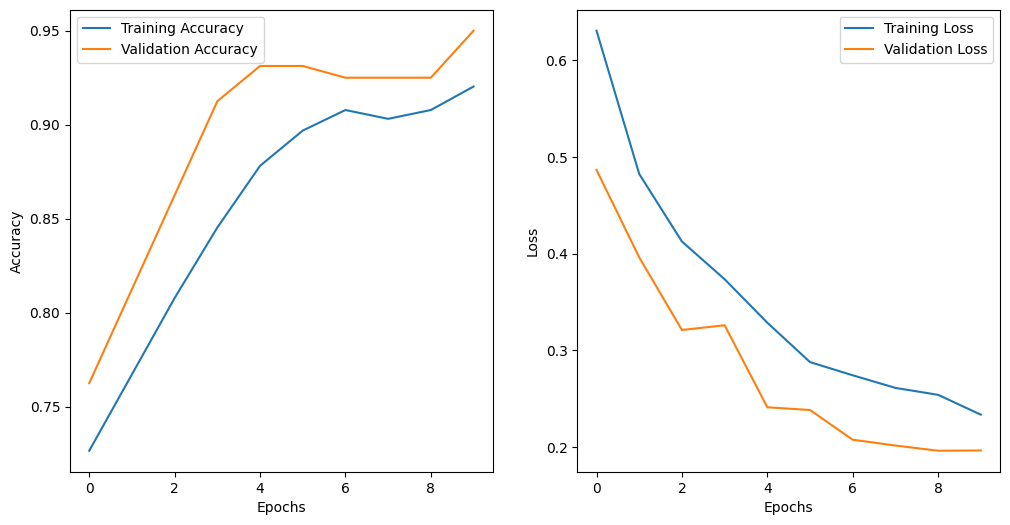

In [33]:
cached_vgg_best_params = {'batch_size': 32, 'loss': 'binary_crossentropy', 'optimizer': 'adam'}
vgg_best_params = cached_vgg_best_params

best_vgg_model = DetectorModelBaseVGG19()

best_vgg_model.build()
best_vgg_model.compile(optimizer=vgg_best_params['optimizer'], loss=vgg_best_params['loss'])

vgg_history = best_vgg_model.fit(train_X, train_Y, test_X, test_Y, batch_size=vgg_best_params['batch_size'], epochs=10, verbose=0)

train_X, test_X, train_Y, test_Y = load_data(target='test', random_state=35)

score = best_vgg_model.score(test_X, test_Y)

print("loss:", score[0])
print("accuracy:", score[1])

visualize_data(vgg_history)

In [18]:
best_vgg_model.save(os.path.join(MODEL_SAVE_PATH, 'vgg19.h5'))

In [19]:
resnet_best_params

{'batch_size': 32, 'loss': 'categorical_crossentropy', 'optimizer': 'adam'}

Epoch 1/10
16/16 [==============================] - 6s 188ms/step - loss: 0.8032 - accuracy: 0.6777 - val_loss: 0.6217 - val_accuracy: 0.7734
Epoch 2/10
16/16 [==============================] - 2s 124ms/step - loss: 0.6112 - accuracy: 0.7461 - val_loss: 0.6161 - val_accuracy: 0.7500
Epoch 3/10
16/16 [==============================] - 2s 140ms/step - loss: 0.5675 - accuracy: 0.7773 - val_loss: 0.4810 - val_accuracy: 0.8125
Epoch 4/10
16/16 [==============================] - 2s 136ms/step - loss: 0.5224 - accuracy: 0.7734 - val_loss: 0.5857 - val_accuracy: 0.7578
Epoch 5/10
16/16 [==============================] - 2s 120ms/step - loss: 0.5297 - accuracy: 0.7832 - val_loss: 0.4502 - val_accuracy: 0.7812
Epoch 6/10
16/16 [==============================] - 2s 119ms/step - loss: 0.4983 - accuracy: 0.7852 - val_loss: 0.4647 - val_accuracy: 0.7734
Epoch 7/10
16/16 [==============================] - 2s 120ms/step - loss: 0.4654 - accuracy: 0.8086 - val_loss: 0.4411 - val_accuracy: 0.8125
Epoch 

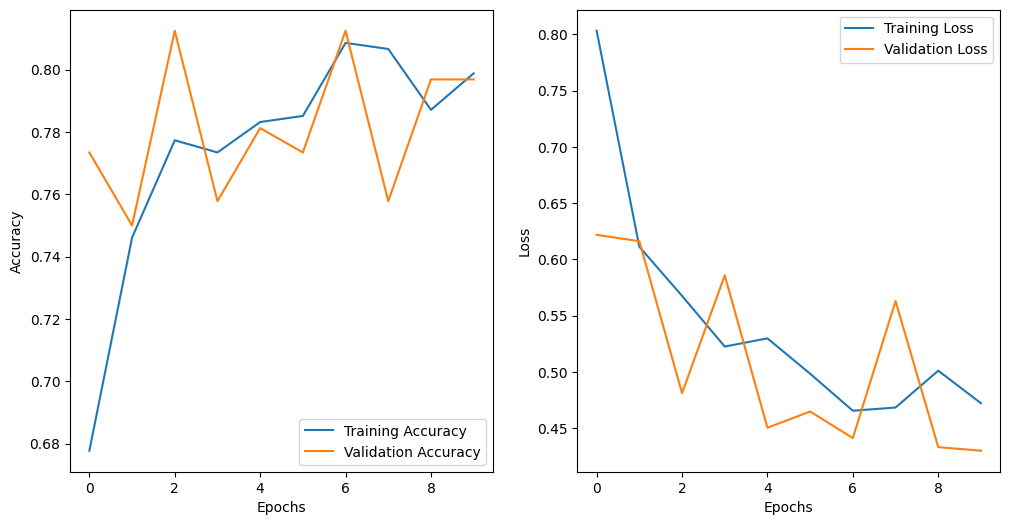

In [34]:
cached_resnet_best_params = {'batch_size': 32, 'loss': 'categorical_crossentropy', 'optimizer': 'adam'}
resnet_best_params = cached_resnet_best_params

best_resnet_model = DetectorModelBaseResNet()
best_resnet_model.model.compile(optimizer=resnet_best_params['optimizer'], loss=resnet_best_params['loss'], metrics=["accuracy"])

resnet_history = best_resnet_model.train(train_X, train_Y, batch_size=resnet_best_params['batch_size'], epochs=10, validation_split=0.2)

train_X, test_X, train_Y, test_Y = load_data(target='test', random_state=35)

score = best_resnet_model.evaluate(test_X, test_Y)

print("loss:", score[0])
print("accuracy:", score[1])

visualize_data(resnet_history)

In [21]:
best_resnet_model.model.save(os.path.join(MODEL_SAVE_PATH, 'resnet.h5'))